In [1]:
%pylab inline
import numpy as np
import itertools
import pandas as pd
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


# The problem of belief structure.

A model of social learning with binary and permanent belief adoption and a finite number of beliefs will always show some form of belief consolidation, and an increase in mean similarity between individuals. However, when we use models to study the effect of diffusion on the emergence of factions or polarization, it's important that the assumed decision logic which relates current beliefs to future adoptions not be informative of the shape of those clusters.  This isn't to say that in the real world there is no shared decision logic, and that this has no influence on what factions are most likely to form. The problem is that if the pattern of clustering is influenced by the decision logic, then the simulation is unable to identify whether clustering can emerge from the diffusion process alone. A simulation in which clustering is a product of either the decision logic or the diffusion process is indeterminate for questions about which creates clustering.

A matrix-of-influence style model, mapping the presence of belief A to changes in the likelihood of adopting belief B will always be informative of the final configuration (or trivial). We can demonstrate this with an extremely simple deterministic model, with no diffusion at all. In this model:

- each agent is exposed to all beliefs in every timestep (making this an individual learning model, not a social learning model)
- having a belief `A` either contributes `+` to an agent's likelihood of adopting belief `B`, or takes away from it `-`
- not having belief `A` has no direct influence on an agent's likelihood of adopting belief `B`
- belief adoption is binary and permenant
- agents adopt if more of their current beliefs suggest they should than suggest they sholdn't (think about a threshold for adoption if $\geq 50 \%$ of existing beliefs are support the adoption of a belief candidate. Other thresholds are of course possible.)

This is the simplest 'matrix-of-influence' style model, and I implement it quite simply in the function `sim`.

In [240]:
def sim(logic, current):
    """
    Simulate an individual's adoption of beliefs, assuming they have access to 
    all beliefs.
    
    logic: n*n matrix 
        in which rows represent the influence of current beliefs on the likelihood 
        of adoption of columns
        
    current: array of length n
        represents the individual's current belief state
        
    returns the agent's steady state belief, once their learning process has completed
    """
    for i in range(400):  # simulate up to 400 steps. We will only hit this value if there is a simulation error.
        adopt = np.dot(current, logic) > 0
        new = np.bitwise_or(current, adopt)
        if np.all(new == current):  # converged
            return tuple(new)
        current = new
    raise ValueError('Logic has not converged after %i steps'%i)

One of the easiest ways to see that the matrix of influence is responsible for creating clusters is to show that different matricies create different numbers of clusters from the same starting conditions. If everything else is the same, except for the matrix itself, then the matrix must be responsible for the clustering. 

To start from a condition of lowest possible clustering, I'll define a population in which each individual has a unique set of beliefs - no clusters exist at all, or to put it another way, there are $2^{(number~of~beliefs)}$ individuals, each forming a cluster of size 1.

Then we'll have each individual learn, according to a shared logic, and group individuals into clusters who are identical to one another.

The two different matrices are generated randomly, by flipping a coin to determine if each square is a positive or negative influence on adoption. The diagonals are blank because once a belief has been adopted, it stays adopted, and so it is meaningless to say that it has an influence (positive or negative) on it's own adoption. 

In [456]:
n_beliefs = 6

logic1 = np.random.choice([-1,  1], size=(n_beliefs, n_beliefs)) * (1-np.identity(n_beliefs))
# for all the different possible combinations of belief for an individual
results = [sim(logic1, current) for current in itertools.product([0, 1], repeat=n_beliefs)]
df1 = pd.DataFrame(results)

In [443]:
logic2 = np.random.choice([-1,  1], size=(n_beliefs, n_beliefs)) * (1-np.identity(n_beliefs))
results = [sim(logic2, current) for current in itertools.product([0, 1], repeat=n_beliefs)]
df2 = pd.DataFrame(results)

In [468]:
pd.to_pickle([logic1, df1, logic2, df2], 'belief_structure.pickle')

In [5]:
n_beliefs = 6
[logic1, df1, logic2, df2] = pd.read_pickle('belief_structure.pickle')

In [7]:
def sorter(df):
    df['sum'] = df.sum(axis=1)
    df2 = df.sort_values(by=['sum']+list(range(n_beliefs)), axis=0)
    return df2.drop(labels='sum', axis=1)

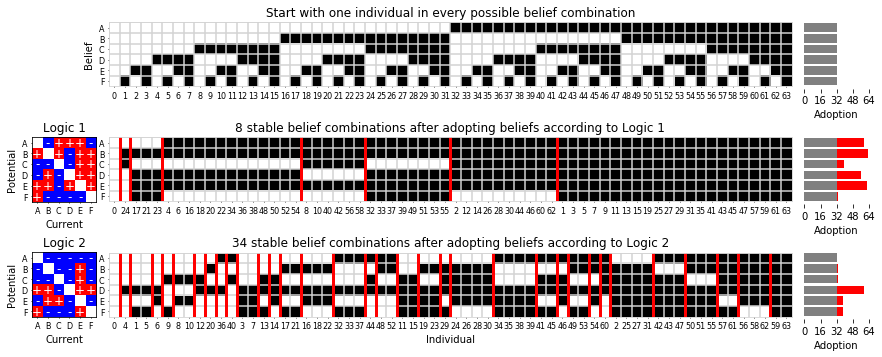

In [8]:
n_cols = 11
plt.rcParams = plt.rcParamsDefault

beliefs = ['A','B','C','D','E','F']
plt.figure(figsize(15,6))

# Starting Conditions
ax1 = plt.subplot2grid(shape=(3, n_cols), loc=(0,1), colspan=n_cols-2)
ax1.imshow(pd.DataFrame(list(itertools.product([0, 1], repeat=n_beliefs))).T, 
           interpolation='nearest', cmap='binary')
ax1.tick_params(length=1)
ax1.set_yticks(range(n_beliefs))
ax1.set_yticklabels(beliefs, fontsize=8)
ax1.set_ylabel('Belief')
ax1.set_xticks(np.arange(0, 2**n_beliefs, 1))
ax1.set_xticklabels(np.arange(0, 2**n_beliefs, 1), fontsize=8)
ax1.set_title('Start with one individual in every possible belief combination')
for spine in ax1.spines.values():
        spine.set_edgecolor('lightgrey')

## grid lines        
ax1.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax1.tick_params(length=0, which='minor')
ax1.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1.5, axis='both')


# Histogram starting conditions
ax8 = plt.subplot2grid(shape=(3, n_cols), loc=(0,n_cols-1))
ax8.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='grey')
ax8.set_yticks([])
ax8.set_xlim(0,64)
ax8.set_aspect(64/6)
for spine in ax8.spines.values():
        #spine.set_edgecolor('lightgrey')
        spine.set_alpha(0)
ax8.set_xticks([0,16,32,48,64]) 
ax8.set_xlabel('Adoption')

# Logic 1
ax2 = plt.subplot2grid(shape=(3, n_cols), loc=(1,0))
ax2.imshow(logic1.T, cmap='bwr')
ax2.set_xticks(range(n_beliefs))
ax2.set_xticklabels(beliefs, fontsize=8)
ax2.set_yticks(range(n_beliefs))
ax2.set_yticklabels(beliefs, fontsize=8)
ax2.set_xlabel('Current')
ax2.set_ylabel('Potential')
ax2.tick_params(length=1)
ax2.set_title('Logic 1')
for i in range(n_beliefs):
    for j in range(n_beliefs):
        text = ax2.text(i, j, '+' if logic1[i, j] == 1 else '-',
                       ha="center", va="center", color="w", fontsize=12)


# Final Conditions after Logic 1
ax3 = plt.subplot2grid(shape=(3, n_cols), loc=(1,1), colspan=n_cols-2)
#sorted_df = df1.sort_values(by=list(range(n_beliefs)), axis=0).T
sorted_df = sorter(df1).T
ax3.imshow(sorted_df, interpolation='nearest', cmap='binary')
ax3.tick_params(length=1)
ax3.set_yticks(range(n_beliefs))
ax3.set_yticklabels(beliefs, fontsize=8)
ax3.set_xticks(np.arange(0, 2**n_beliefs, 1))
ax3.set_xticklabels(sorted_df.columns, fontsize=8)
for spine in ax3.spines.values():
        spine.set_edgecolor('lightgrey')

## grid lines        
ax3.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax3.tick_params(length=0, which='minor')
ax3.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1.5, axis='both')

## cluster marks
sorted_df.columns=range(2**n_beliefs)
changes = sorted_df.diff(axis=1).any()
xs = np.array(changes[changes].index)-.5
ax3.vlines(xs, -.5, n_beliefs-.5, colors='r', linewidth=3)
ax3.set_title('%i stable belief combinations after adopting beliefs according to Logic 1'%(len(xs)+1));



# Histogram after Logic 1
ax6 = plt.subplot2grid(shape=(3, n_cols), loc=(1,n_cols-1))
ax6.barh(range(n_beliefs), list(reversed(sorted_df.sum(axis=1))), color='r')
ax6.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='grey')
ax6.set_yticks([])
ax6.set_xlim(0,64)
ax6.set_aspect(64/6)
for spine in ax6.spines.values():
        #spine.set_edgecolor('lightgrey')
        spine.set_alpha(0)
ax6.set_xticks([0,16,32,48,64])
ax6.set_xlabel('Adoption')
        

# Final conditions after Logic 2
ax4 = plt.subplot2grid(shape=(3, n_cols), loc=(2,1), colspan=n_cols-2)
#sorted_df = df2.sort_values(by=list(range(n_beliefs)), axis=0).T
sorted_df = sorter(df2).T
ax4.imshow(sorted_df, interpolation='nearest', cmap='binary')
ax4.tick_params(length=1)
ax4.set_xlabel('Individual')
ax4.set_yticks(range(n_beliefs))
ax4.set_yticklabels(beliefs, fontsize=8)
ax4.set_xlabel('Individual')
ax4.set_xticks(np.arange(0, 2**n_beliefs, 1))
ax4.set_xticklabels(sorted_df.columns, fontsize=8)
for spine in ax4.spines.values():
        spine.set_edgecolor('lightgrey')

## gridlines
ax4.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax4.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax4.tick_params(length=0, which='minor')
ax4.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1.5, axis='both')
#ax4.box('off')

## cluster marks
sorted_df.columns=range(2**n_beliefs)
changes = sorted_df.diff(axis=1).any()
xs = np.array(changes[changes].index)-.5
ax4.vlines(xs, -.5, n_beliefs-.5, colors='r', linewidth=3)
ax4.set_title('%i stable belief combinations after adopting beliefs according to Logic 2'%(len(xs)+1));


# Logic 2
ax5 = plt.subplot2grid(shape=(3, n_cols), loc=(2,0))
ax5.imshow(logic2.T, cmap='bwr')
ax5.set_xticks(range(n_beliefs))
ax5.set_xticklabels(beliefs, fontsize=8)
ax5.set_yticks(range(n_beliefs))
ax5.set_yticklabels(beliefs, fontsize=8)
ax5.set_xlabel('Current')
ax5.set_ylabel('Potential')
ax5.tick_params(length=1)
ax5.set_title('Logic 2')
for i in range(n_beliefs):
    for j in range(n_beliefs):
        text = ax5.text(i, j, '+' if logic2[i, j] == 1 else '-',
                       ha="center", va="center", color="w", fontsize=12)

# Histogram after Logic 2
ax7 = plt.subplot2grid(shape=(3, n_cols), loc=(2,n_cols-1))
#ax6.get_shared_y_axes().join(ax3, ax6)
ax7.barh(range(n_beliefs), list(reversed(sorted_df.sum(axis=1))), color='r')
ax7.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='grey')
ax7.set_yticks([])
ax7.set_xlim(0,64)
ax7.set_aspect(64/6)
for spine in ax7.spines.values():
        #spine.set_edgecolor('lightgrey')
        spine.set_alpha(0)
ax7.set_xlabel('Adoption')
ax7.set_xticks([0,16,32,48,64]);

plt.savefig('figS1 interdependence matrix problems.svg')
plt.savefig('figS1 interdependence matrix problems.png', bbox_inches='tight', dpi=150)

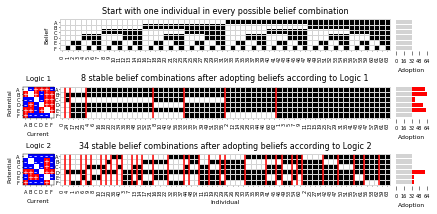

In [76]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams["font.size"] = 10
plt.rcParams["lines.markersize"] = 6
#plt.rcParams['axes.grid'] = True
#plt.rcParams['axes.grid.axis'] = 'both'
#plt.rcParams['grid.alpha'] = .5
#plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = .5
#plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
#plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['figure.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 8
#plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.framealpha'] =.7
plt.rcParams['legend.title_fontsize'] = 8


n_cols = 11

beliefs = ['A','B','C','D','E','F']
plt.figure(figsize=(7.25,3.5))

# Starting Conditions
ax1 = plt.subplot2grid(shape=(3, n_cols), loc=(0,1), colspan=n_cols-2)
ax1.imshow(pd.DataFrame(list(itertools.product([0, 1], repeat=n_beliefs))).T, 
           interpolation='nearest', cmap='binary')
ax1.tick_params(length=1)
ax1.set_yticks(range(n_beliefs))
ax1.set_yticklabels(beliefs, ha='center')
ax1.set_ylabel('Belief')
ax1.set_xticks(np.arange(0, 2**n_beliefs, 1))
labels = ax1.set_xticklabels(np.arange(0, 2**n_beliefs, 1))
plt.setp(labels, rotation=90)
ax1.set_title('Start with one individual in every possible belief combination')
for spine in ax1.spines.values():
        spine.set_edgecolor('lightgrey')

## grid lines        
ax1.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax1.tick_params(length=0, which='minor')
ax1.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1, axis='both')


# Histogram starting conditions
ax8 = plt.subplot2grid(shape=(3, n_cols), loc=(0,n_cols-1))
ax8.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='lightgrey')
ax8.set_yticks([])
ax8.set_xlim(0,64)
ax8.set_aspect(64/6)
for spine in ax8.spines.values():
        #spine.set_edgecolor('lightgrey')
        spine.set_alpha(0)
ax8.set_xticks([0,16,32,48,64]) 
ax8.set_xlabel('Adoption')

# Logic 1
ax2 = plt.subplot2grid(shape=(3, n_cols), loc=(1,0))
ax2.imshow(logic1.T, cmap='bwr')
ax2.set_xticks(range(n_beliefs))
ax2.set_xticklabels(beliefs)
ax2.set_yticks(range(n_beliefs))
ax2.set_yticklabels(beliefs, ha='center')
ax2.set_xlabel('Current')
ax2.set_ylabel('Potential')
ax2.tick_params(length=1)
ax2.set_title('Logic 1', fontsize=7)
for i in range(n_beliefs):
    for j in range(n_beliefs):
        text = ax2.text(i, j, '+' if logic1[i, j] == 1 else '-',
                       ha="center", va="center", color="w",
                       fontsize = 7 if logic1[i, j] == 1 else 9)
plt.setp(ax2.spines.values(), linewidth=.4)


# Final Conditions after Logic 1
ax3 = plt.subplot2grid(shape=(3, n_cols), loc=(1,1), colspan=n_cols-2)
#sorted_df = df1.sort_values(by=list(range(n_beliefs)), axis=0).T
sorted_df = sorter(df1).T
ax3.imshow(sorted_df, interpolation='nearest', cmap='binary')
ax3.tick_params(length=1)
ax3.set_yticks(range(n_beliefs))
ax3.set_yticklabels(beliefs, ha='center')
ax3.set_xticks(np.arange(0, 2**n_beliefs, 1))
labels = ax3.set_xticklabels(sorted_df.columns)
plt.setp(labels, rotation=90)
ax3.tick_params(axis='y', pad=2)

for spine in ax3.spines.values():
        spine.set_edgecolor('lightgrey')

## grid lines        
ax3.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax3.tick_params(length=0, which='minor')
ax3.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1, axis='both')

## cluster marks
sorted_df.columns=range(2**n_beliefs)
changes = sorted_df.diff(axis=1).any()
xs = np.array(changes[changes].index)-.5
ax3.vlines(xs, -.5, n_beliefs-.5, colors='r', linewidth=1.5)
ax3.set_title('%i stable belief combinations after adopting beliefs according to Logic 1'%(len(xs)+1));



# Histogram after Logic 1
ax6 = plt.subplot2grid(shape=(3, n_cols), loc=(1,n_cols-1))
ax6.barh(range(n_beliefs), list(reversed(sorted_df.sum(axis=1))), color='r')
ax6.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='lightgrey')
ax6.set_yticks([])
ax6.set_xlim(0,64)
ax6.set_aspect(64/6)
for spine in ax6.spines.values():
        #spine.set_edgecolor('lightgrey')
        spine.set_alpha(0)
ax6.set_xticks([0,16,32,48,64])
ax6.set_xlabel('Adoption')
        

# Final conditions after Logic 2
ax4 = plt.subplot2grid(shape=(3, n_cols), loc=(2,1), colspan=n_cols-2)
#sorted_df = df2.sort_values(by=list(range(n_beliefs)), axis=0).T
sorted_df = sorter(df2).T
ax4.imshow(sorted_df, interpolation='nearest', cmap='binary')
ax4.tick_params(length=1)
ax4.set_xlabel('Individual')
ax4.set_yticks(range(n_beliefs))
ax4.set_yticklabels(beliefs, ha='center')
ax4.set_xlabel('Individual')
ax4.set_xticks(np.arange(0, 2**n_beliefs, 1))
labels = ax4.set_xticklabels(sorted_df.columns)
plt.setp(labels, rotation=90)
ax4.tick_params(axis='y', pad=2)

for spine in ax4.spines.values():
        spine.set_edgecolor('lightgrey')

## gridlines
ax4.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax4.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax4.tick_params(length=0, which='minor')
ax4.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1, axis='both')
#ax4.box('off')

## cluster marks
sorted_df.columns=range(2**n_beliefs)
changes = sorted_df.diff(axis=1).any()
xs = np.array(changes[changes].index)-.5
ax4.vlines(xs, -.5, n_beliefs-.5, colors='r', linewidth=1.5)
ax4.set_title('%i stable belief combinations after adopting beliefs according to Logic 2'%(len(xs)+1));


# Logic 2
ax5 = plt.subplot2grid(shape=(3, n_cols), loc=(2,0))
ax5.imshow(logic2.T, cmap='bwr')
ax5.set_xticks(range(n_beliefs))
ax5.set_xticklabels(beliefs)
ax5.set_yticks(range(n_beliefs))
ax5.set_yticklabels(beliefs, ha='center')


ax5.set_xlabel('Current')
ax5.set_ylabel('Potential')
ax5.tick_params(length=1)
ax5.set_title('Logic 2', fontsize=7)
for i in range(n_beliefs):
    for j in range(n_beliefs):
        text = ax5.text(i, j, '+' if logic2[i, j] == 1 else '-',
                       ha="center", va="center", color="w", 
                       fontsize = 7 if logic2[i, j] == 1 else 9)
plt.setp(ax5.spines.values(), linewidth=.4)

# Histogram after Logic 2
ax7 = plt.subplot2grid(shape=(3, n_cols), loc=(2,n_cols-1))
#ax6.get_shared_y_axes().join(ax3, ax6)
ax7.barh(range(n_beliefs), list(reversed(sorted_df.sum(axis=1))), color='r')
ax7.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='lightgrey')
ax7.set_yticks([])
ax7.set_xlim(0,64)
ax7.set_aspect(64/6)
for spine in ax7.spines.values():
        #spine.set_edgecolor('lightgrey')
        spine.set_alpha(0)
ax7.set_xlabel('Adoption')
ax7.set_xticks([0,16,32,48,64]);

plt.savefig('figS1 interdependence matrix problems.svg')
plt.savefig('figS1 interdependence matrix problems.png', bbox_inches='tight', dpi=150)

# triangle closing

In [9]:
initial_adoptions = list(itertools.product([0, 1], repeat=n_beliefs))
edges = [('P', 'Q'), ('P', 'R'), ('P', 'S'), ('Q', 'R'), ('Q', 'S'), ('R', 'S')]


#list(itertools.product([0, 1], repeat=n_beliefs)
agents = [nx.from_edgelist(list(itertools.compress(edges, initial_adoptions[i]))) for i in range(2**6)]

def triangle_closure(g):
    for source, length_dict in nx.shortest_path_length(g):
        for dest, length in length_dict.items():
            if length == 2:
                g.add_edges_from([(source, dest)])
    edgelist = g.edges()
    return [1 if edge in edgelist else 0 for edge in edges]
                
df3 = pd.DataFrame([triangle_closure(g) for g in agents]  )

/Users/jameshoughton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


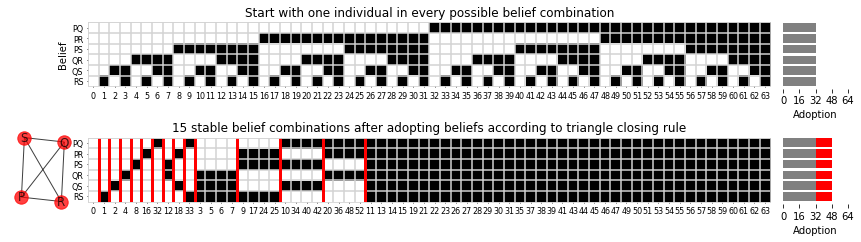

In [11]:
# Large figure
plt.rcParams = plt.rcParamsDefault
n_cols = 11

beliefs = ['PQ','PR','PS','QR','QS','RS']
plt.figure(figsize(15,6))

# Starting Conditions
ax1 = plt.subplot2grid(shape=(3, n_cols), loc=(0,1), colspan=n_cols-2)
ax1.imshow(pd.DataFrame(initial_adoptions).T, 
           interpolation='nearest', cmap='binary')
ax1.tick_params(length=1)
ax1.set_yticks(range(n_beliefs))
ax1.set_yticklabels(beliefs, fontsize=8)
ax1.set_ylabel('Belief')
ax1.set_xticks(np.arange(0, 2**n_beliefs, 1))
ax1.set_xticklabels(np.arange(0, 2**n_beliefs, 1), fontsize=8)
ax1.set_title('Start with one individual in every possible belief combination')
for spine in ax1.spines.values():
        spine.set_edgecolor('lightgrey')

## grid lines        
ax1.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax1.tick_params(length=0, which='minor')
ax1.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1.5, axis='both')


# Display complete semantic network
ax2 = plt.subplot2grid(shape=(3, n_cols), loc=(1,0))
nx.draw_networkx(agents[-1], ax=ax2, node_size=180, alpha=.75)
for spine in ax2.spines.values():
        spine.set_alpha(0)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)


# Histogram starting conditions
ax8 = plt.subplot2grid(shape=(3, n_cols), loc=(0,n_cols-1))
ax8.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='grey')
ax8.set_yticks([])
ax8.set_xlim(0,64)
ax8.set_aspect(64/6)
for spine in ax8.spines.values():
        #spine.set_edgecolor('lightgrey')
        spine.set_alpha(0)
ax8.set_xticks([0,16,32,48,64]) 
ax8.set_xlabel('Adoption')



# Final Conditions after triangle closing
ax3 = plt.subplot2grid(shape=(3, n_cols), loc=(1,1), colspan=n_cols-2)
sorted_df = sorter(df3).T
ax3.imshow(sorted_df, interpolation='nearest', cmap='binary')
ax3.tick_params(length=1)
ax3.set_yticks(range(n_beliefs))
ax3.set_yticklabels(beliefs, fontsize=8)
ax3.set_xticks(np.arange(0, 2**n_beliefs, 1))
ax3.set_xticklabels(sorted_df.columns, fontsize=8)
for spine in ax3.spines.values():
        spine.set_edgecolor('lightgrey')

## grid lines        
ax3.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax3.tick_params(length=0, which='minor')
ax3.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1.5, axis='both')

## cluster marks
sorted_df.columns=range(2**n_beliefs)
changes = sorted_df.diff(axis=1).any()
xs = np.array(changes[changes].index)-.5
ax3.vlines(xs, -.5, n_beliefs-.5, colors='r', linewidth=3)
ax3.set_title('%i stable belief combinations after adopting beliefs according to triangle closing rule'%(len(xs)+1));


# Histogram after triangle closing
ax6 = plt.subplot2grid(shape=(3, n_cols), loc=(1,n_cols-1))
ax6.barh(range(n_beliefs), list(reversed(sorted_df.sum(axis=1))), color='r')
ax6.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='grey')
ax6.set_yticks([])
ax6.set_xlim(0,64)
ax6.set_aspect(64/6)
for spine in ax6.spines.values():
        spine.set_alpha(0)
ax6.set_xticks([0,16,32,48,64])
ax6.set_xlabel('Adoption');

plt.savefig('figS2 triangle closing.svg')
plt.savefig('figS2 triangle closing.png', bbox_inches='tight', dpi=150)

/Users/jameshoughton/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


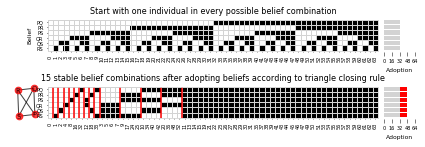

In [77]:
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams["font.size"] = 10
plt.rcParams["lines.markersize"] = 6
#plt.rcParams['axes.grid'] = True
#plt.rcParams['axes.grid.axis'] = 'both'
#plt.rcParams['grid.alpha'] = .5
#plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = .5
#plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
#plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['figure.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 8
#plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.framealpha'] =.7
plt.rcParams['legend.title_fontsize'] = 8


n_cols = 11

beliefs = ['PQ','PR','PS','QR','QS','RS']
plt.figure(figsize=(7.25,3.5))

# Starting Conditions
ax1 = plt.subplot2grid(shape=(3, n_cols), loc=(0,1), colspan=n_cols-2)
ax1.imshow(pd.DataFrame(initial_adoptions).T, 
           interpolation='nearest', cmap='binary')
ax1.tick_params(length=1)
ax1.set_yticks(range(n_beliefs))
ax1.set_yticklabels(beliefs)
ax1.set_ylabel('Belief')
ax1.set_xticks(np.arange(0, 2**n_beliefs, 1))
labels = ax1.set_xticklabels(np.arange(0, 2**n_beliefs, 1))
plt.setp(labels, rotation=90)
ax1.set_title('Start with one individual in every possible belief combination')
for spine in ax1.spines.values():
        spine.set_edgecolor('lightgrey')

## grid lines        
ax1.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax1.tick_params(length=0, which='minor')
ax1.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1, axis='both')


# Display complete semantic network
ax2 = plt.subplot2grid(shape=(3, n_cols), loc=(1,0))
nx.draw_networkx(agents[-1], ax=ax2, node_size=45, alpha=.75, font_size=7)
for spine in ax2.spines.values():
        spine.set_alpha(0)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlim(-1.8,1.8)
ax2.set_ylim(-2,2)


# Histogram starting conditions
ax8 = plt.subplot2grid(shape=(3, n_cols), loc=(0,n_cols-1))
ax8.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='lightgrey')
ax8.set_yticks([])
ax8.set_xlim(0,64)
ax8.set_aspect(64/6)
for spine in ax8.spines.values():
        #spine.set_edgecolor('lightgrey')
        spine.set_alpha(0)
ax8.set_xticks([0,16,32,48,64]) 
ax8.set_xlabel('Adoption')



# Final Conditions after triangle closing
ax3 = plt.subplot2grid(shape=(3, n_cols), loc=(1,1), colspan=n_cols-2)
sorted_df = sorter(df3).T
ax3.imshow(sorted_df, interpolation='nearest', cmap='binary')
ax3.tick_params(length=1)
ax3.set_yticks(range(n_beliefs))
ax3.set_yticklabels(beliefs)
ax3.set_xticks(np.arange(0, 2**n_beliefs, 1))
labels = ax3.set_xticklabels(sorted_df.columns)
plt.setp(labels, rotation=90)
for spine in ax3.spines.values():
        spine.set_edgecolor('lightgrey')

## grid lines        
ax3.set_xticks(np.arange(-.5, 2**n_beliefs-.5, 1), minor=True);
ax3.set_yticks(np.arange(-.5, n_beliefs-.5, 1), minor=True);
ax3.tick_params(length=0, which='minor')
ax3.grid(which='minor', color='lightgrey', linestyle='-', linewidth=1, axis='both')

## cluster marks
sorted_df.columns=range(2**n_beliefs)
changes = sorted_df.diff(axis=1).any()
xs = np.array(changes[changes].index)-.5
ax3.vlines(xs, -.5, n_beliefs-.5, colors='r', linewidth=1.5)
ax3.set_title('%i stable belief combinations after adopting beliefs according to triangle closing rule'%(len(xs)+1));


# Histogram after triangle closing
ax6 = plt.subplot2grid(shape=(3, n_cols), loc=(1,n_cols-1))
ax6.barh(range(n_beliefs), list(reversed(sorted_df.sum(axis=1))), color='r')
ax6.barh(range(n_beliefs), [2**(n_beliefs-1)]*n_beliefs, color='lightgrey')
ax6.set_yticks([])
ax6.set_xlim(0,64)
ax6.set_aspect(64/6)
for spine in ax6.spines.values():
        spine.set_alpha(0)
ax6.set_xticks([0,16,32,48,64])
ax6.set_xlabel('Adoption');

#plt.tight_layout(h_pad)
plt.savefig('figS2 triangle closing.svg')
plt.savefig('figS2 triangle closing.png', bbox_inches='tight', dpi=150)